# INTRODUCTION

## Libraries

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE

from keras import layers, models, Sequential, regularizers
from keras.layers import SimpleRNN, Dense, Dropout, Embedding, LSTM, GRU
from keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.regularizers import L1, L2, L1L2

import keras_tuner as kt

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Import data & column groups

In [49]:
DAILY_DATA_PATH = "data.v3/daily" 

df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7',]

## Train Test Split - "flights_ontime"

In [50]:
# Select features and targets
train_features = ['random'] + date_cols + weather_cols + lag_cols
targets = flights_non_terminal_cols + flights_percentage_cols

# Create X and y
X = df[train_features].drop('date', axis=1)
y = df[targets]

# Split data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y['flights_ontime'], test_size=0.1, random_state=42)

# Split data into X_train_rull and y_train_full into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# Print shapes
print("X_train_full shape:", X_train_full.shape)
print("y_train_full shape:", y_train_full.shape)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_Test shape:", X_test.shape)
print("y_Test shape:", y_test.shape)

X_train_full shape: (1516, 54)
y_train_full shape: (1516,)
X_train shape: (1364, 54)
y_train shape: (1364,)
X_Test shape: (169, 54)
y_Test shape: (169,)


# PREPROCESS FOR DENSE NETWORK

In [51]:
print(f"Feature names: {X.columns.tolist()}")
print(f"Target columns: {y.columns.tolist()}", end="\n\n")
print("Unique data types in X", X.dtypes.value_counts(), sep = '\n')

# Identify categorical and numeric columns in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()

print(f"\nCategorical columns to one-hot-encode: {categorical_cols}")

# Fit transformers to the training data
f_scaler = StandardScaler()
f_scaler.fit(X_train[numeric_cols])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Some observed holidays may not be in the training data
ohe.fit(X_train[categorical_cols])

t_scaler = StandardScaler()
t_scaler.fit(y_train.values.reshape(-1, 1)) # reshape y_train to be 2D

# Define preprocessor
def preprocess(features, target, set_global_scaler = False):
    global global_targer_scaler

    scaled_features = f_scaler.transform(features[numeric_cols])
    encoded_features = ohe.transform(features[categorical_cols])
    scaled_target = t_scaler.transform(target.values.reshape(-1, 1))
    processed_features = np.concatenate([scaled_features, encoded_features], axis=1)

    if set_global_scaler:
        global_targer_scaler = t_scaler

    return processed_features, scaled_target

# Preprocess the data
X_train_d, y_train_d = preprocess(X_train, y_train, set_global_scaler=True)
X_val_d, y_val_d = preprocess(X_val, y_val)

Feature names: ['random', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction', 'flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7', 'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7', 'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7

# ONE-NEURON "LINEAR MODEL"

The goal of this section is to simulate linear regression using a neural newtork with one neuron and no activation function. I'll use L1 and L2 regularization to simulate elastic net regression and compare results to those found in 3.daily_linear_regression.ipynb.

## Create TensorFlow datasets

In [52]:
# TensorFlow datasets
train_ds_flights_ontime_d = Dataset.from_tensor_slices((X_train_d, y_train_d)).shuffle(len(X_train_d))
val_ds_flights_ontime_d = Dataset.from_tensor_slices((X_val_d, y_val_d)).shuffle(len(X_val_d))

# Batch and prefetch
batch_size = 32
train_ds_flights_ontime_d = train_ds_flights_ontime_d.batch(batch_size).prefetch(AUTOTUNE)
val_ds_flights_ontime_d = val_ds_flights_ontime_d.batch(batch_size).prefetch(AUTOTUNE)


## Create R-squared metric

In [53]:
from keras import backend as K

def r_squared(y_true, y_pred):
    y_true_inv = tf.numpy_function(global_targer_scaler.inverse_transform, [y_true], tf.float32)
    y_pred_inv = tf.numpy_function(global_targer_scaler.inverse_transform, [y_pred], tf.float32)
    SS_res =  K.sum(K.square(y_true_inv - y_pred_inv)) 
    SS_tot = K.sum(K.square(y_true_inv - K.mean(y_true_inv))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Build one-neuron hypermodel

In [54]:
def model_builder(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    l1_regularization = hp.Float('l1_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)
    l2_regularization =  hp.Float('l2_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)

    model = Sequential([
        Dense(units = 1, 
            input_dim=X_train_d.shape[1], 
            kernel_regularizer=L1L2(l1_regularization, l2_regularization))
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mean_squared_error', 
                metrics=['mean_absolute_error', r_squared])
    
    return model

## Get one-neuron hyperparameters using Keras random search tuner

In [55]:
# Callbacks & Tensorboard Setup
early_stopping_1n_RS = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a Keras Tuner
OneNeuron_tuner_RS = kt.RandomSearch(
    hypermodel = model_builder,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    directory='logs/flights_ontime/dense_lr/',
    project_name='tuner',
    overwrite = True
)

In [56]:
# Search for best hyperparameters
OneNeuron_tuner_RS.search(train_ds_flights_ontime_d, 
             validation_data=val_ds_flights_ontime_d, 
             epochs=500, 
             callbacks=[early_stopping_1n_RS])

Trial 100 Complete [00h 00m 04s]
val_loss: 0.4413934797048569

Best val_loss So Far: 0.39084501564502716
Total elapsed time: 00h 13m 05s


## Best 3 one-neuron fits: hyperparameters and validation score

In [57]:
OneNeuron_tuner_RS.results_summary(num_trials=3)

Results summary
Results in logs/flights_ontime/dense_lr/tuner
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 009 summary
Hyperparameters:
learning_rate: 0.008962452499275811
l1_regularization: 1.0584371677401203e-05
l2_regularization: 0.0006047479526432094
Score: 0.39084501564502716

Trial 030 summary
Hyperparameters:
learning_rate: 0.008531793184908256
l1_regularization: 0.00019600863707131832
l2_regularization: 0.003617130412055955
Score: 0.4029093086719513

Trial 001 summary
Hyperparameters:
learning_rate: 0.005074107037826867
l1_regularization: 2.3330194220626485e-05
l2_regularization: 6.293819544114347e-05
Score: 0.4051011651754379


## Get model weights and save best one-neuron model

In [58]:
# Get best hyperparameters
best_hps = OneNeuron_tuner_RS.get_best_hyperparameters(num_trials = 1)[0]

# Tensorboard setup
!rm -rf ./logs/flights_ontime/OneNeuron/tensorboard/ 
log_dir = "logs/flights_ontime/OneNeuron/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_best = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

best_hps = OneNeuron_tuner_RS.get_best_hyperparameters(num_trials = 1)[0]
OneNeuron_LR_model = OneNeuron_tuner_RS.hypermodel.build(best_hps)
history = OneNeuron_LR_model.fit(train_ds_flights_ontime_d, 
                    validation_data=val_ds_flights_ontime_d, 
                    epochs=500, 
                    callbacks=[early_stopping_best, tensorboard_callback],
                    verbose=0)

# Save the trained model
OneNeuron_LR_model.save('models/flights_ontime/OneNeuron_LR_model')

INFO:tensorflow:Assets written to: models/flights_ontime/OneNeuron_LR_model/assets


INFO:tensorflow:Assets written to: models/flights_ontime/OneNeuron_LR_model/assets


##  TensorBoard for best 1-neuron model
The TensorBoard dashboard shows plots generated from training logs that provide insight into the training of a model. 

The time series tab shows several plots within expandable windows for our one-neuronal model, "dense_#" and for the loss and training metrics by epoch.  Under dense_#, TesnorBoard shows histograms of the bias values "bias_0" and weight values, "kernel_0" by epoch. The epoch number is on the y-axis with the first epochs at the top and the most recent epoch at the bottom. These plots show how the bias and weight distributions change with training. For the one-neuron model, the weights appear to stabilize well before the training ended, at around 50 to 60 epochs, while the bias terms continued to drift downwards with training.

The other plots under Time Series show how the loss and metrics change with training epoch or iteration (batch number). Based on these plots, the one-neuron model appears to have high bias and high variance. High bias is indicated by the large difference in loss and performance metrics between the train and validation datasets. High variance is indicated by the large variation in the validation loss, mae, and r-squared metrics that persists through training, even after these metrics stabilize on the training set at around epoch 40. Taken together, the one-neuron model appears to lack flexibility and would also benefit from having more data to train the weights.




In [59]:
%tensorboard --logdir logs/flights_ontime/OneNeuron/tensorboard

## Load and evalute the best 1-neuron model

In [72]:
# Load the trained model
OneNeuron_LR_model = models.load_model('models/flights_ontime/OneNeuron_LR_model', custom_objects={'r_squared': r_squared})

# Inverse transform the predicted values and get validation MAE, MSE, and R^2
y_pred = OneNeuron_LR_model.predict(X_val_d)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_d)

# Calculate metrics
OneNeuron_val_r2 = r2_score(y_val_inv, y_pred_inv)
OneNeuron_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
OneNeuron_val_mse = mean_squared_error(y_val_inv, y_pred_inv)
OneNeuron_val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_inv)

# Save metrics in a dictionary
val_performance = {'OneNeuron_LR':{'r2': OneNeuron_val_r2,
                                   'mae': OneNeuron_val_mae,
                                   'mse': OneNeuron_val_mse,
                                   'mape': OneNeuron_val_mape
                                   }
}

print(f"""Validation Metrics:
- Validation R^2: {OneNeuron_val_r2:.3f}
- Validation MAE: {OneNeuron_val_mae:.2f}
- Validation MSE: {OneNeuron_val_mse:.2f}
- Validation MAPE: {OneNeuron_val_mape:.2f}
""")

5/5 [==============================] - 0s 548us/step
Validation Metrics:
- Validation R^2: 0.693
- Validation MAE: 114.15
- Validation MSE: 31404.82
- Validation MAPE: 0.12



# SHALLOW DENSE NEURAL NETWORK (SDNN)

## Build SDNN Hypermodel

In [61]:
def build_model(hp):
    n_input_neurons = hp.Int('n_input_neurons', min_value=4, max_value=16, default=8)
    n_hidden_neurons = hp.Int('n_hidden_neurons', min_value=4, max_value=16, default=8)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    dropout_rate = hp.Float('dropout_rate', min_value=0.02, max_value=0.03, default=0.0)
    l2_regularization =  hp.Float('l2_regularization', min_value=1e-5, max_value=1e-1, sampling='LOG', default=1e-2)

    model = Sequential()

    # Input layer
    model.add(Dense(units=n_input_neurons, 
                    activation='relu', 
                    kernel_regularizer=L2(l2_regularization)))
    model.add(Dropout(dropout_rate))
    
    # Hidden layer
    model.add(Dense(units=n_hidden_neurons, 
                    activation='relu', 
                    kernel_regularizer=L2(l2_regularization)))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model

## Get hyperparameters for SDNN using Bayesian optimization

In [62]:
early_stopping_BO = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

SDNN_tuner_BO = kt.BayesianOptimization(
    hypermodel = build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    num_initial_points=2,
    directory = "logs/flights_ontime/SDNN",
    project_name = "bayesian_optimization_tuner",
    overwrite=True
)

SDNN_tuner_BO.search(train_ds_flights_ontime_d, 
             epochs=500, 
             validation_data=val_ds_flights_ontime_d, 
             callbacks=[early_stopping_BO])

Trial 100 Complete [00h 00m 15s]
val_loss: 0.490376815199852

Best val_loss So Far: 0.3861648142337799
Total elapsed time: 00h 07m 46s


## Get hyperparameters for SDNN using random search
In the interest of time, I didn't use the random search tuner on the last training run. This approach consistently underperformed compared to Bayesian optimization and hyperband.

In [ ]:
# early_stopping_RS = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# SDNN_tuner_RS = kt.RandomSearch(
#     hypermodel = build_model,
#     objective='val_loss',
#     max_trials=100,
#     executions_per_trial=2,
#     directory = "logs/flights_ontime/SDNN",
#     project_name = "random_search_tuner",
#     overwrite=True
# )

# SDNN_tuner_RS.search(train_ds_flights_ontime_d,
#                 epochs=500, 
#                 validation_data=val_ds_flights_ontime_d, 
#                 callbacks=[early_stopping_RS])

## Get hyperparameters for best SDNN model using hyperband

In [63]:
early_stopping_HB = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

SDNN_tuner_HB = kt.Hyperband(
    hypermodel = build_model,
    objective='val_loss',
    max_epochs=600,
    factor=3,
    directory = "logs/flights_ontime/SDNN",
    project_name = "hyperband_tuner",
    overwrite=True
)

SDNN_tuner_HB.search(train_ds_flights_ontime_d,
                epochs=600, 
                validation_data=val_ds_flights_ontime_d, 
                callbacks=[early_stopping_HB])

Trial 725 Complete [00h 00m 02s]
val_loss: 0.48776185512542725

Best val_loss So Far: 0.35990238189697266
Total elapsed time: 00h 16m 07s


## Get weights and save best SDNN model (from hyperband search)

In [64]:
# Get best hyperparameters from Hyperband tuner
best_hps = SDNN_tuner_HB.get_best_hyperparameters(num_trials = 1)[0]

# Initialize Early Stopping
early_stopping_SDNN_best = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Setup TensoreBoard
!rm -rf ./logs/flights_ontime/SDNN_HB/tensorboard/
log_dir = "logs/flights_ontime/SDNN_HB/tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with the best hyperparameters
SDNN_model = SDNN_tuner_HB.hypermodel.build(best_hps)
history = SDNN_model.fit(train_ds_flights_ontime_d, 
                    validation_data=val_ds_flights_ontime_d, 
                    epochs=500, 
                    callbacks=[early_stopping_SDNN_best, tensorboard_callback],
                    verbose=0)

# Save the trained model
SDNN_model.save('models/flights_ontime/SDNN_model')

INFO:tensorflow:Assets written to: models/flights_ontime/SDNN_model/assets


INFO:tensorflow:Assets written to: models/flights_ontime/SDNN_model/assets


## TensorBoard

In [12]:
# TensorBoard
%tensorboard --logdir logs/flights_ontime/SDNN_HB/tensorboard

Reusing TensorBoard on port 6007 (pid 38246), started 0:00:20 ago. (Use '!kill 38246' to kill it.)

## Best SDNN model summary

In [66]:
# Load the trained model
SDNN_model = models.load_model('models/flights_ontime/SDNN_model')

# Print the best hyperparameters
print(f"""Best Hyperparameters:
- Number of Input Neurons: {best_hps.get('n_input_neurons')}
- Number of Hiden Layer Neurons: {best_hps.get('n_hidden_neurons')}
- Learning Rate: {best_hps.get('learning_rate')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- L2 Regularization: {best_hps.get('l2_regularization')}
""")

Best Hyperparameters:
- Number of Input Neurons: 5
- Number of Hiden Layer Neurons: 11
- Learning Rate: 0.008278432590472753
- Dropout Rate: 0.022090435869564898
- L2 Regularization: 0.0004675390559078446



## Model architecture

In [67]:
SDNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 485       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 11)                66        
                                                                 
 dropout_3 (Dropout)         (None, 11)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 12        
                                                                 
Total params: 563 (2.20 KB)
Trainable params: 563 (2.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Best SDNN model evaluation

In [73]:
# Inverse transform the predicted values and get validation MAE, MSE
y_pred = SDNN_model.predict(X_val_d)
y_pred_inv = global_targer_scaler.inverse_transform(y_pred)
y_val_inv = global_targer_scaler.inverse_transform(y_val_d)

SDNN_R2 = r2_score(y_val_inv, y_pred_inv)
SDNN_val_mae = mean_absolute_error(y_val_inv, y_pred_inv)
SDNN_val_mse = mean_squared_error(y_val_inv, y_pred_inv)
SDNN_val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_inv)

# Add metrics to the dictionary
val_performance['SDNN'] = {'r2': SDNN_R2,
                           'mae': SDNN_val_mae,
                           'mse': SDNN_val_mse,
                           'mape': SDNN_val_mape
                           }

print(f"""Validation Metrics:
- Validation R^2: {SDNN_R2:.3f}
- Validation MAE: {SDNN_val_mae:.2f}
- Validation MSE: {SDNN_val_mse:.2f}
- Validation MAPE: {SDNN_val_mape:.2f}
""")

5/5 [==============================] - 0s 607us/step
Validation Metrics:
- Validation R^2: 0.683
- Validation MAE: 119.03
- Validation MSE: 32442.40
- Validation MAPE: 0.13



### Save validation performance as csv

In [74]:
df = pd.DataFrame(val_performance).T
df['model'] = df.index
df = df.reset_index(drop=True)
df = df[['model', 'r2', 'mae', 'mse', 'mape']]
print(df)
df.to_csv('model_output/dense_nn_results.csv', index=False)

          model        r2         mae           mse      mape
0  OneNeuron_LR  0.692926  114.147327  31404.819429  0.119560
1          SDNN  0.682780  119.027114  32442.398737  0.128941


# MODEL TYPE COMPARISON

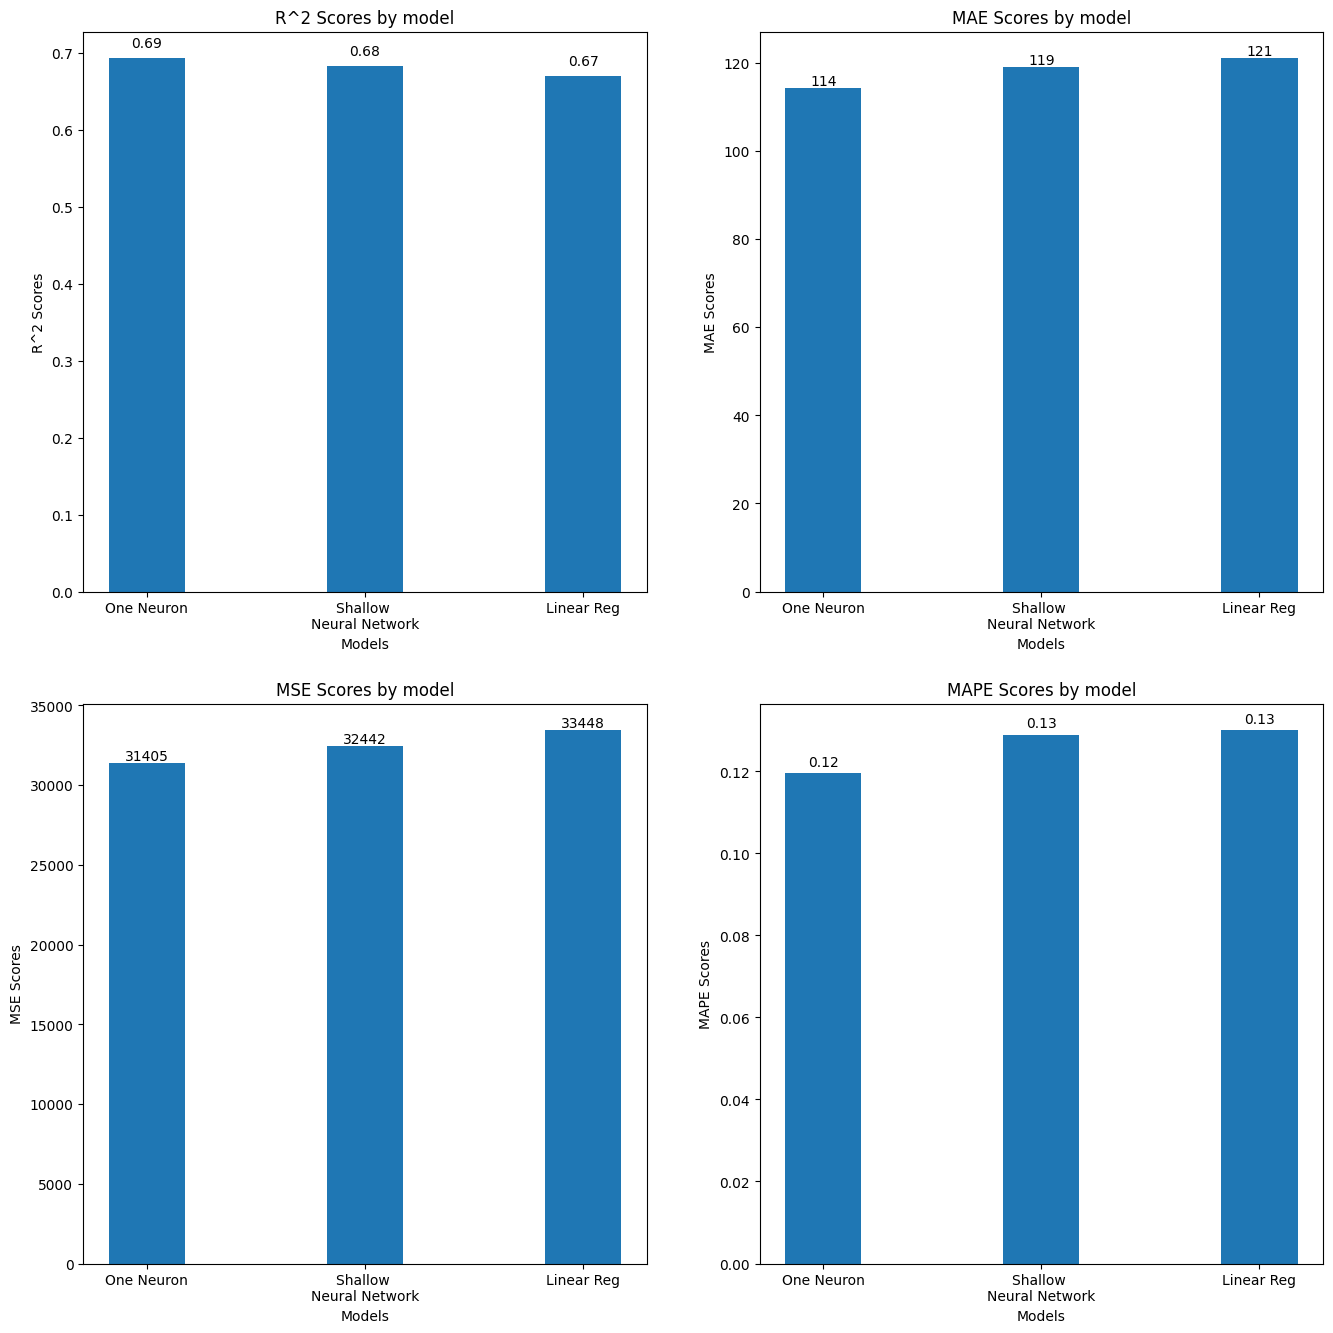

In [76]:
# Get the Elastic Net metrics
EN_data = pd.read_csv("model_output/elastic_net_results.csv")
LR_r2 = EN_data.loc[EN_data['TARGET'] == 'flights_ontime', 'R2'].values[0]
LR_mae = EN_data.loc[EN_data['TARGET'] == 'flights_ontime', 'MAE'].values[0]
LR_mse = EN_data.loc[EN_data['TARGET'] == 'flights_ontime', 'MSE'].values[0]
LR_mape = EN_data.loc[EN_data['TARGET'] == 'flights_ontime', 'MAPE'].values[0]

# Get the Time Series metrics
TS_data = pd.read_csv("model_output/TimeSeries_results.csv")


models = ['Linear Reg', 'One Neuron', 'Shallow \nNeural Network']
r2 = [LR_r2, OneNeuron_val_r2, SDNN_R2]
mae = [LR_mae, OneNeuron_val_mae, SDNN_val_mae]
mse = [LR_mse, OneNeuron_val_mse, SDNN_val_mse]
mape = [LR_mape, OneNeuron_val_mape, SDNN_val_mape]

# Sort by R^2
sorted_indices_r2 = np.argsort(r2)[::-1]
sorted_models_r2 = [models[i] for i in sorted_indices_r2]
sorted_r2 = [r2[i] for i in sorted_indices_r2]

# Sort by MAE
sorted_indices_mae = np.argsort(mae)
sorted_models_mae = [models[i] for i in sorted_indices_mae]
sorted_mae = [mae[i] for i in sorted_indices_mae]

# Sort by MSE
sorted_indices_mse = np.argsort(mse)
sorted_models_mse = [models[i] for i in sorted_indices_mse]
sorted_mse = [mse[i] for i in sorted_indices_mse]

# Sort by MAPE
sorted_indices_mape = np.argsort(mape)
sorted_models_mape = [models[i] for i in sorted_indices_mape]
sorted_mape = [mape[i] for i in sorted_indices_mape]

x = np.arange(len(models))
bar_width = 0.35

fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

# R^2
bars_r2 = axes[0,0].bar(x, sorted_r2, bar_width, label='R^2')
axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('R^2 Scores')
axes[0,0].set_title('R^2 Scores by model')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(sorted_models_r2)

# Add values above R^2 bars
for bar, value in zip(bars_r2, sorted_r2):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{value:.2f}', ha='center', va='bottom')

# MAE
bars_mae = axes[0,1].bar(x, sorted_mae, bar_width, label='MAE')
axes[0,1].set_xlabel('Models')
axes[0,1].set_ylabel('MAE Scores')
axes[0,1].set_title('MAE Scores by model')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(sorted_models_mae)

# Add values above MAE bars
for bar, value in zip(bars_mae, sorted_mae):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{value:.0f}', ha='center', va='bottom')

# MSE
bar_mse = axes[1,0].bar(x, sorted_mse, bar_width, label='MSE')
axes[1,0].set_xlabel('Models')
axes[1,0].set_ylabel('MSE Scores')
axes[1,0].set_title('MSE Scores by model')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(sorted_models_mse)

# Add values above MSE bars
for bar, value in zip(bar_mse, sorted_mse):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{value:.0f}', ha='center', va='bottom')

# MAPE
bar_mape = axes[1,1].bar(x, sorted_mape, bar_width, label='MAPE')
axes[1,1].set_xlabel('Models')
axes[1,1].set_ylabel('MAPE Scores')
axes[1,1].set_title('MAPE Scores by model')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(sorted_models_mape)

# Add values above MAPE bars
for bar, value in zip(bar_mape, sorted_mape):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width() / 2, height + 0.001, f'{value:.2f}', ha='center', va='bottom')
    

plt.tight_layout
plt.show()

# SUMMARY & CONCLUSION

Both single neuron and shallow dense neural networks were able to at least match, if not slightly improve upon, the prediction accuracy of mutlilple linear regression applied to ontime flights. Three different keras tuners were used to search hypermodels for optimum hyperparameters, including the number of hidden layers, number of neurons per layer, learning rate, dropout rate, regularization rate, and optimizer algorithm. The Hyperband tuner consistently found the best hyperparameters, but required the longest search time. The most influential hyperparameters proved to be the learning rate, regularization rates, and dropout rates. Eventually, I dropped the number of layers and optimizer type from the hyperparameter search in favor of a single hidden layer and the Adam optimimzer, as they generally showed the best results. One implication is that complex interactions that would be revealed by complex architectures are unlikely to figure prominently in this dataset.

The TensorBoard module proved to be an effective tool for evaluating a model fit, easily displaying loss and metric plots that show if the model is over or under trained and if high bias or high variance exist. Plots for the bias and weights within each layer of a network help reveal the stability of the training process

One major flaw in this analysis is the data splitting used for the RNN models. The data should have been split sequentially with training data comning before validation data conming before test data. Instead the data were shuffled before splitting, meaning that the each dataset contains non-sequential data, which is fine for linear regression and the dense neural networks, problematic for the RNN time series analysis. Additionally, I failed to take the additional steps to Window the data and create tensors for the inputs and labels of each window. Having discovered these mistakes near the submission deadline, I decided to write my summary and conclusion before attempting to fix the errors.  Now that I've produced a summary of the work to date, I will begin a new notebook, 5.DFW_daily_flights_LSTM that follows methods used in the [TensorFlow timeseries tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series). I won't have time to write a separate summary and conclusion for this additional code, so please consider this to "supplmental" material.